In [1]:
import torch
import numpy as np
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from tqdm import trange

from models.GraphESN import GraphESN

from DMD.dmd import KANN

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
dataset = TUDataset(root='/ESGNN/data/MUTAG', name='MUTAG')
# dataset = dataset.shuffle()

In [3]:
len(dataset)

188

In [4]:
dataset[0]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

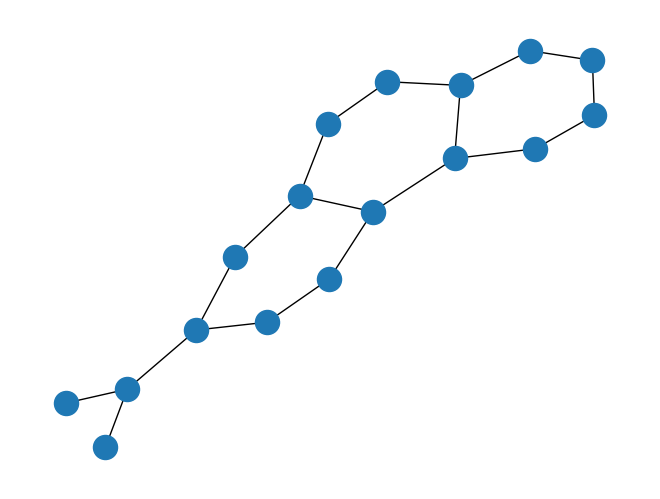

In [3]:
edge_index = dataset[0]['edge_index']
x = dataset[0]['x']
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [9]:
dataset[0]['y']

tensor([1])

In [3]:
model = GraphESN(input_size=7,
                hidden_size=100,
                steps=50,
                input_scaling=1.,
                num_layers=1,
                leaking_rate=0.9,
                spectral_radius=0.9,
                density=0.9,
                activation='tanh',
                alpha_decay=False)


In [4]:
embs = []
for g in dataset:
    embs.append(model(g['x'], g['edge_index']).sum(dim=0))
embs = torch.stack(embs).to(device)

In [40]:
embs.shape

torch.Size([188, 100])

In [9]:
classifier = torch.nn.Sequential(
    torch.nn.Linear(model.hidden_size, 2),
    torch.nn.Softmax(dim=-1)
    ).to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 100
classifier.train()
losses = []

for epoch in trange(epochs):
    for i in range(embs.shape[0]//2):
        out = classifier(embs[i,:])
        optimizer.zero_grad()
        loss = loss_fn(out, (dataset[i]['y'].squeeze()/2+0.5).type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()
        losses.append(loss)

100%|██████████| 100/100 [00:06<00:00, 14.71it/s]


In [10]:
classifier.eval()
test = 0

for i in range(embs.shape[0]//2,embs.shape[0]):
    test += torch.argmax(classifier(embs[i,:]).cpu()) == dataset[i]['y']

print(float(test/(embs.shape[0]//2)))

0.6063829660415649


In [93]:
koops = []

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0) # add batch dim

    # compute Koopman operator
    kann_ = KANN(state.cpu(), k=50, emb='TruncatedSVD')
    C = kann_.compute_KOP()
    koops.append(C.flatten())

koops = torch.from_numpy(np.stack(koops)).to(device)

In [96]:
koops.shape

torch.Size([188, 2500])

In [104]:
state_classifier = torch.nn.Sequential(
    torch.nn.Linear(koops.shape[1], 2),
    torch.nn.Softmax(dim=-1)
    ).to(device)

state_optimizer = torch.optim.Adam(state_classifier.parameters(), lr=0.01)
loss_fn2 = torch.nn.CrossEntropyLoss()
epochs = 100
state_classifier.train()
losses = []

for epoch in trange(epochs):
    for i in range(koops.shape[0]//2):
        out = state_classifier(koops[i,:])
        state_optimizer.zero_grad()
        loss = loss_fn2(out, (dataset[i]['y'].squeeze()/2+0.5).type(torch.LongTensor).to(device))
        loss.backward()
        state_optimizer.step()
        losses.append(loss)

100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


In [105]:
state_classifier.eval()
test = 0

for i in range(koops.shape[0]//2, koops.shape[0]):
    test += torch.argmax(state_classifier(koops[i,:])) == dataset[i]['y'].to(device)

print(float(test/(koops.shape[0]//2)))

0.6063829660415649


In [4]:
state = model(dataset[0]['x'], dataset[0]['edge_index'])

In [9]:
state.shape

torch.Size([17, 100])

In [10]:
len(model.states)

11

In [6]:
model.states[0].shape

torch.Size([17, 100])

In [14]:
H = torch.stack(model.states[1:], dim=1)
H = torch.cat([H[k,:,:] for k in range(H.shape[0])], dim=-1)
H = H.unsqueeze(dim=0) # add batch dim

In [15]:
H.shape

torch.Size([1, 50, 1700])

- perform SVD on states H
- you get new states Zp with smaller dimensions
- find Koopman operator C that approximates Zp dynamics

In [16]:
# compute Koopman operator
kann_ = KANN(H.cpu(), emb=None)
C = kann_.compute_KOP()
D, V = np.linalg.eig(C)
U = np.linalg.inv(V)

maybe use this instead to reduce the dimensionality?

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing/blob/master/code/tensorPCA.py

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


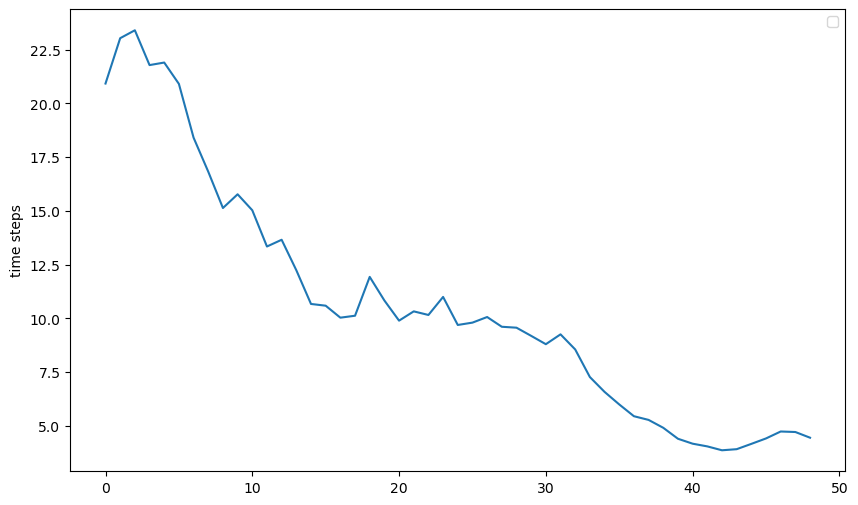

In [19]:
plt.figure(figsize=(10,6))
t = [i for i in range(H.shape[1]-1)]
plt.plot(t, torch.linalg.vector_norm(H[:,:-1,:]-H[:,1:,:], dim=(0,2)))
plt.ylabel('time steps')
plt.legend()
plt.show() 

In [20]:
np.allclose(C,(V @ np.diag(D) @ U)) # it should return True

False

In [ ]:
# Q: What's the difference between this and what has ben done above?
# A: Matrix C is already squared because states H were already transformed with SVD
# so diagonalisation or SVD lead to the same results
Un, S, Vh = np.linalg.svd(C)

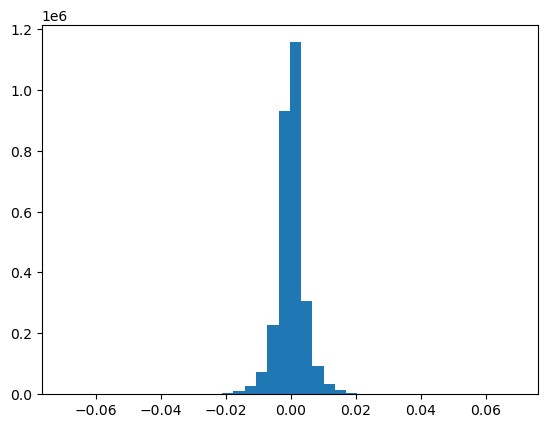

In [21]:
fig, ax = plt.subplots()
# the histogram of the data
n, bins, patches = ax.hist(C.flatten(), 40, density=False)

plt.show() 

In [22]:
(C>0.01).sum()

56324

Plot Zp states:
- only the first one seems relevant

In [23]:
kann_.Zp.shape

torch.Size([1, 50, 1700])

In [ ]:
# plt.figure(figsize=(10,6))
# t = [i for i in range(H.shape[1])]
# for n in range(kann_.Zp.shape[-1]):
#     plt.plot(t, kann_.Zp.squeeze()[:,n], label=f'{n}')
# # plt.yscale('log')
# plt.ylabel('time steps')
# plt.legend()
# plt.show() 

- the first eigenvalue is the biggest
- it's close to 1, so the exponential dynamics doesn't kill it

In [26]:
D.shape

(1700,)

In [29]:
(np.absolute(D)>0.8).sum()

45

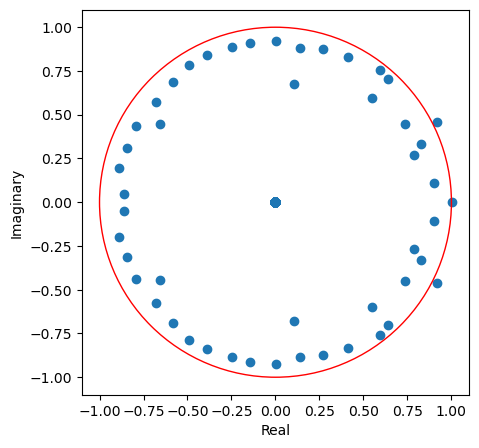

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(D.real, D.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show() 

Let's approximate Zp dynamics with C

In [30]:
kann_.Zp.shape

torch.Size([1, 50, 1700])

In [34]:
first_Z = kann_.Zp.squeeze()[0,:].numpy()
newZp = np.stack([C**n @ first_Z for n in range(model.steps)])[np.newaxis,:,:]

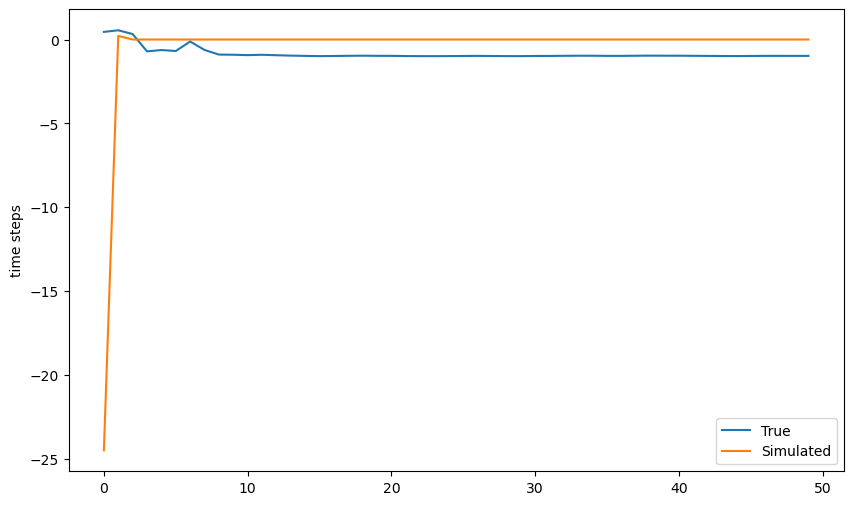

In [36]:
# plot the first one to check

plt.figure(figsize=(10,6))
t = [i for i in range(H.shape[1])]
plt.plot(t, kann_.Zp.squeeze()[:,0], label='True')
plt.plot(t, newZp.squeeze()[:,0], label='Simulated')
# plt.yscale('log')
plt.ylabel('time steps')
plt.legend()
plt.show() 

Let's project states newZp onto the most important eignvector

In [58]:
np.absolute(D)

array([1.0062362 , 0.72079212, 0.72079212, 0.42902767, 0.42902767,
       0.31037689, 0.31037689, 0.27858445])

In [37]:
V[:,0].shape

(1700,)

In [60]:
scal = V[:,0].T @ newZp.squeeze().T # scalar product with eigenvector
proj = np.stack([V[:,0]*s for s in scal]) # projection on eigenvector
proj = proj[np.newaxis, :, :] # add batch dim

In [61]:
proj.real.shape

(1, 10, 8)

Then we can recover the original sequence of states

In [62]:
recov = kann_.recover_states(proj.real, kann_.k)

In [63]:
# recover the right shape
new_states = np.stack([recov.squeeze()[:,k*options.dim_hidden:(k+1)*options.dim_hidden] for k in range(recov.shape[-1]//options.dim_hidden)], axis=-1)
new_states = torch.tensor(new_states)
# add bias, for reasons...
final_state_w_bias = torch.cat((new_states[-1,:,:], model.bias * torch.ones(1, new_states[-1,:,:].shape[1], device=model.device)), dim=0)

In [64]:
# send it through the model
model.test_only(final_state_w_bias)

tensor([[-8.8677e+13, -8.6985e+13, -6.5358e+13, -8.0969e+13, -8.0395e+13,
         -6.5702e+13, -7.8691e+13, -6.7746e+13, -8.7596e+13, -8.6922e+13,
         -6.8813e+13, -7.9994e+13, -8.2263e+13, -7.9814e+13, -5.7326e+13,
         -5.8948e+13, -5.7479e+13, -6.1286e+13, -2.1879e+13,  1.1953e+14,
          1.2132e+14]])

In [67]:
te_acc = torch.sum(torch.sign(model.test_only(final_state_w_bias)) ==
                           target[-graph]) / model.test_only(final_state_w_bias).shape[-1]
print(te_acc)

tensor(0.0952)


Can we plot the states back to the original graph?

In [68]:
imp = torch.softmax(torch.sum(new_states[-1,:,:],dim=0),dim=0) # numbers are too big
print(imp)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.])


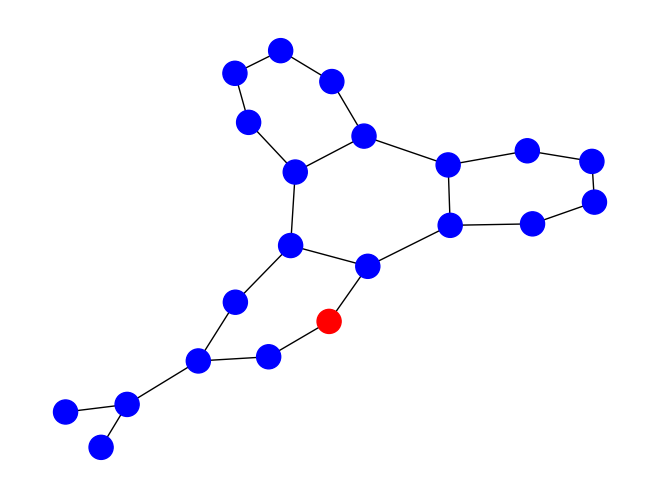

In [69]:
edge_index = adj_mats[-graph].to_sparse().indices().cpu()
x = node_labels[-graph].cpu()
colors = ['r' if n==1.0 else 'b' for n in imp]
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, node_color=colors)